<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-setup" data-toc-modified-id="Code-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Read-items-from-ENM-preprocessing" data-toc-modified-id="Read-items-from-ENM-preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read items from ENM preprocessing</a></span></li><li><span><a href="#Read-organics-data" data-toc-modified-id="Read-organics-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Read organics data</a></span></li><li><span><a href="#Imputation-for-log(density)" data-toc-modified-id="Imputation-for-log(density)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Imputation for log(density)</a></span></li><li><span><a href="#Organics-dataframes" data-toc-modified-id="Organics-dataframes-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Organics dataframes</a></span></li><li><span><a href="#Organics-WF-bins" data-toc-modified-id="Organics-WF-bins-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Organics WF bins</a></span></li></ul></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Data-distributions" data-toc-modified-id="Data-distributions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data distributions</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Hierarchical-Agglomerative-Clustering-(HAC)" data-toc-modified-id="Hierarchical-Agglomerative-Clustering-(HAC)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Hierarchical Agglomerative Clustering (HAC)</a></span></li></ul></li></ul></div>

# Code setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To suppress warning output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys

# To make this notebook's output stable across runs
np.random.seed(42)

In [2]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['axes.titlesize'] = 'x-large' #16
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [4]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt
importlib.reload(blt);

Figure directory exists.
Figure directory exists.


# Data

## Read items from ENM preprocessing

These will be used to help shape the organics data frame.

In [6]:
# Import data frame headings from target model (before pre-processing)
enm_cols = []
with open('./data/column-headers.txt', 'r') as filehandle:  
    for line in filehandle:
        # Remove linebreak which is the last character of the string
        currentCol = line[:-1]
        # Add item to the list
        enm_cols.append(currentCol)

In [7]:
# Read pre-processed ENM data (before applying feature reduction)
X_enm = pd.read_csv("./data/ENM-pre-preprocessed-feats.csv", 
                    sep='\t', index_col=0)
X_enm.head(4)

,cprp_MW,cprp_MP,cprp_BP,cprp_logdensity,func_absorbent,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,func_biocide,func_brightener,...,pgrp_fungicide,pgrp_generalhouseholdcleaning,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_paintstainrelatedproducts,pgrp_sunscreen,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,2972.0,0.626340,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,63.546,1083.00,2567.0,0.952308,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,65.370,419.53,907.0,0.853698,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,107.868,961.78,2162.0,1.014730,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
# Dataframe for only ENM functional uses for feature agglomeration later
Xf_enm = X_enm[X_enm.columns[pd.Series(X_enm.columns).str.startswith('func')]]

# Dataframe for only ENM product categories for feature agglomeration later
filter_col = [c for c in X_enm if c.startswith('pgen') or c.startswith('pgrp')]
Xp_enm = X_enm[filter_col]

## Read organics data

In [9]:
# Read in organcis potential predictive variables ("features")
X_source = pd.read_csv("./data/organics-clean.csv", sep=',', index_col=0)

# Read in organics weight fraction data
y_source = pd.read_csv("./data/organics-clean.csv", sep=',', usecols=[2])

print([X_source.shape, y_source.shape])

[(29373, 87), (29373, 1)]


In [10]:
# Clean feature data and column names

# Drop unwanted columns (CASRN, WF, product type, chem-props unused in ENM df)
X_source.drop(X_source.columns[[0,1,4,8,9,10,11,14,15,17]], 
              axis=1, inplace=True)

# Rename columns
X_source.columns = X_source.columns.str.replace('_','')
X_source.rename(columns = {'gencatID':'pgen', 
                        'group':'pgrp', 
                        'refinedproducttype':'refined', 
                        'assignedID':'mtrx', 
                        'uvstabilizer':'UVstabilizer'
                       }, inplace=True)

# Clean up data in refined column so it's only spray vs NOC
X_source.loc[X_source.refined != 'spray', 'refined'] = 'NOC'

# Transform factor data (product categories) into binary columns
X_source = pd.get_dummies(X_source, 
                          prefix=["pgen","pgrp","refined","mtrx"], 
                          columns=["pgen","pgrp","refined","mtrx"])

# Remove spaces from column names
X_source.columns = X_source.columns.str.replace(' ','')
X_source.columns = X_source.columns.str.replace('/','')
X_source.columns = X_source.columns.str.replace('-','')
X_source.columns = X_source.columns.str.replace('and','')

# Edit column name prefixes and suffixes for consistency and clarity
X_source.columns = X_source.columns.str.replace('prop','cprp_')
X_source.columns = X_source.columns.str.replace('refined','mtrx')
X_source.columns = X_source.columns.str.replace('mtrx_F','mtrx_formulation')

# Add 'func' prefix to functional uses
cols = X_source.columns
idx_func = np.asarray([i for i, c in enumerate(cols) if not '_' in c])
X_source.rename(columns={c: '_'.join(('func', c)) for c in cols[idx_func]}, 
                inplace=True)

# Log-transform density so that it's no longer skewed
X_source['cprp_logdensity'] = X_source['cprp_Density'].apply(np.log10)

In [11]:
# If there are ENM features not present in organics df, add them

# List differences between feature sets
cols_add = list(set(enm_cols) - set(X_source.columns.tolist()))
# Assign these features to organics df with default values of zero
for col in cols_add:
    X_source[col] = 0

In [12]:
# Delete unwanted samples

# Restructure organics features df to match ENM df
X_source = X_source[enm_cols]
# Temporarily add WF labels to df
X_source = pd.concat([y_source, X_source], axis=1)
# Delete rows that are missing important chemical property data
X_source = X_source[X_source['cprp_MP'].notnull()] # delete missing data
# Remove outlier lacking density data
X_source = X_source[X_source['cprp_MP'] > -170]
# Delete rows that don't have enough data (ones)
X_source = X_source[X_source.iloc[:,5:].sum(axis=1) > 2]
print(X_source.shape)

(16439, 46)


In [13]:
# Extract wf labels (y) from new X_source
y_source = X_source[['maximum_weight_fraction']]
X_source.drop(X_source.columns[[0]], axis=1, inplace=True)
print(y_source.shape)

(16439, 1)


In [14]:
# Preview final main dataframe
X_source.tail(5)

,cprp_MW,cprp_MP,cprp_BP,cprp_logdensity,func_absorbent,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,func_biocide,func_brightener,...,pgrp_fungicide,pgrp_generalhouseholdcleaning,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_paintstainrelatedproducts,pgrp_sunscreen,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
29366,152.149,84.03215,263.941,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
29367,152.149,84.03215,263.941,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29368,152.149,84.03215,263.941,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
29369,135.210,-31.78080,203.080,-0.031517,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29370,135.210,-31.78080,203.080,-0.031517,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Imputation for log(density)

In [15]:
# How much density data is missing?
print(X_source[~X_source['cprp_logdensity'].notnull()].shape)

# Percent of density data missing
len(X_source[~X_source['cprp_logdensity'].notnull()])/len(X_source)

(639, 45)


0.038870977553379156

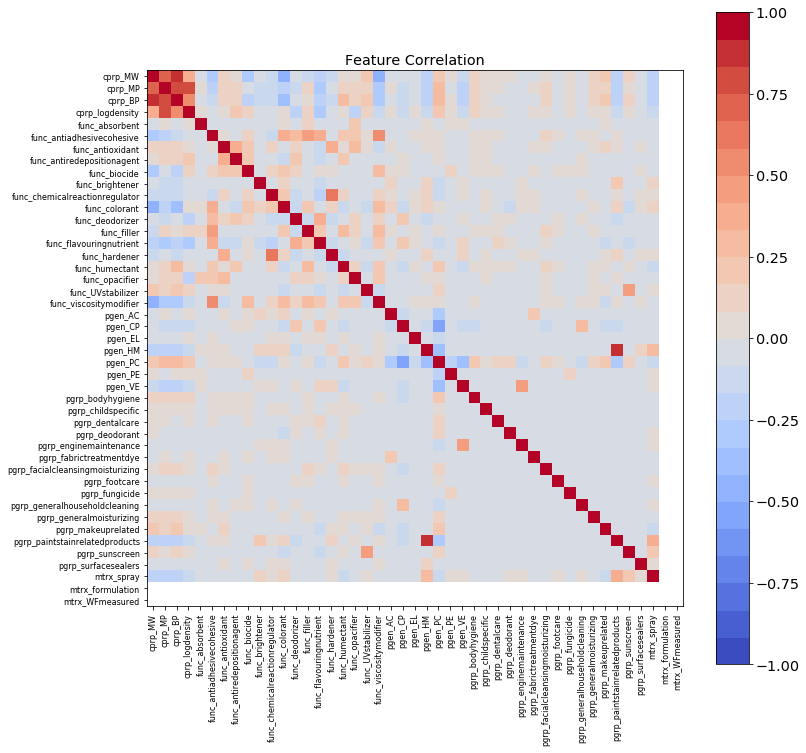

In [16]:
# Get feature correlation to determine best independent variable for imputation
def correlation_matrix(df):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    cmap = cm.get_cmap('coolwarm', 24)
    cax = ax.imshow(df.corr('spearman'), cmap=cmap, vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    labels = df.columns.tolist()
    ax.set_xticks(range(len(df.columns)))
    ax.set_yticks(range(len(df.columns)))
    ax.set_xticklabels(labels,fontsize=8, rotation=90)
    ax.set_yticklabels(labels,fontsize=8)
    fig.colorbar(cax)
    plt.show()
correlation_matrix(X_source)

In order to find missing values for density, imputation will be performed using linear regression. Melting point has the highest correlation with density and will therefore be used as the independent variable.
Assuming the line of best fit for a set of points is given by:

$y = a + b x$

where:

$b = \Large{\frac{\sum x_i  y_i - n \bar x\bar y )} {\sum (x_i - \bar x)^2}} $

and

$a = \bar y - b \bar x$

* To remove outliers: https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html

In [17]:
# Find line of best fit for imputation

# MP and density arrays for continuous data
X = np.array(X_source.loc[X_source.cprp_logdensity.notnull(), ['cprp_MP']])
Y = np.array(X_source.loc[X_source.cprp_logdensity.notnull(), 
                          ['cprp_logdensity']])

# Solve for 'a' and 'b'
def best_fit(X, Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)
    numer = sum(xi*yi for xi,yi in zip(X, Y)) - n * xbar * ybar
    denum = sum(xi**2 for xi in X) - n * xbar**2
    b = numer / denum
    a = ybar - b * xbar
    return a, b

a, b = best_fit(X, Y)

# MP and density arrays for missing data
X_null = np.array(X_source.loc[X_source.cprp_logdensity.isnull(), ['cprp_MP']])
Y_null = b * X_null + a

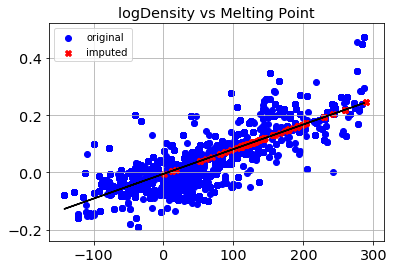

In [18]:
# Plot points and fit line
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, c = 'b', label="original")
ax1.scatter(X_null, Y_null, c = 'r', marker = 'X', label="imputed")
yfit = [a + b * xi for xi in X]
ax1.plot(X, yfit, color='black')

plt.title("logDensity vs Melting Point")
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [19]:
# Put imputed densities into data frame
for idx in X_source.index:
    if pd.isnull(X_source.loc[idx,"cprp_logdensity"]):
        MP = X_source.loc[idx,"cprp_MP"]
        X_source.loc[idx,"cprp_logdensity"] = (b * MP + a)

## Organics dataframes

I split up X_source into a few separate dataframes for looking at data distributions.

In [20]:
# Data frame for only functional use categories
Xf_source = X_source[X_source.columns[pd.Series(X_source.columns).str.startswith('func')]]
source_func_names = [s[5:] for s in list(Xf_source.columns.values)]

# Only product categories
filter_col = [c for c in X_source if c.startswith('pgen') or c.startswith('pgrp')]
Xp_source = X_source[filter_col]
source_PUC_names = [s[5:] for s in list(Xp_source.columns.values)]

# Only chemical properties
Xc_source = X_source[X_source.columns[pd.Series(X_source.columns).str.startswith('cprp')]]

# Only matrix properties
Xm_source = X_source.iloc[:,-3:]
print(Xm_source.columns.values)

['mtrx_spray' 'mtrx_formulation' 'mtrx_WFmeasured']


## Organics WF bins

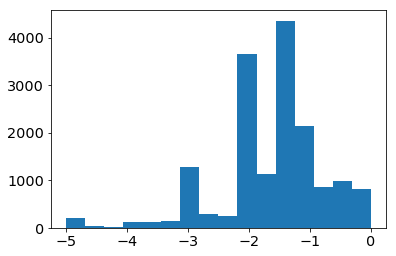

In [21]:
# Log-transformed histogram of weight fraction
plt.hist(np.log10(np.asarray(y_source)+0.00001), bins=16);

In [22]:
# Define function to assign weight fractions to bins per Isaacs et al. 2016
def bins(row):
    if row['maximum_weight_fraction'] <= 0.01:
        val = 'bottom'
    elif row['maximum_weight_fraction'] > 0.05:
        val = 'top'
    else:
        val = 'middle'
    return val
bin_source_isaacs = y_source.apply(bins, axis=1)

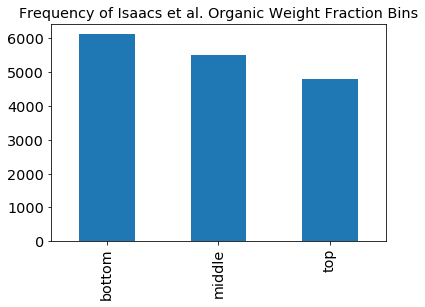

In [23]:
bin_source_isaacs.value_counts()[['bottom','middle','top']].plot(kind='bar')
plt.title('Frequency of Isaacs et al. Organic Weight Fraction Bins');

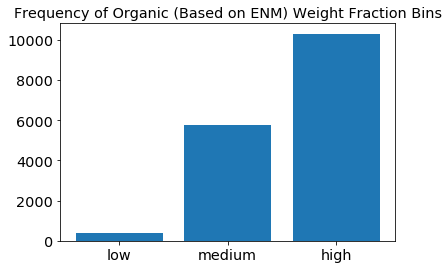

Label bin:  [0 1 2]
Count    :  [  381  5746 10312]
Frequency:  [0.02, 0.35, 0.63]


In [24]:
# Apply bins to organics data
# (slightly different ranges from those used by Isaacs et al. 2016)
bin_source = np.asarray(y_source.apply(blt.bins, axis=1))
# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_source, data_composition='Organic (Based on ENM)')

# Pre-processing

## Data distributions

In [70]:
# Function for plotting piecharts
def plot_piechart(data,
                  labels, 
                  save_fig_name):
    my_colors = ["#1f77b4","#ff7f0e","#ffdf00","#d62728","#9467bd",
                 "#2ca02c","#1034A6","#ffbf33","#8B0000",'teal',
                 "#aada30","#e37799","#17becf","#7f7f7f","#cc0099","#0B6623"]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(data, autopct='%1.1f%%', 
           colors=my_colors, 
           labels=labels, 
           pctdistance=0.9, labeldistance=1.05, 
           startangle=90, counterclock=False, 
           textprops={'fontsize':9})
    ax.axis('equal')
    ax.set_title(save_fig_name, weight="bold")
    fig.savefig('./figs/pie_%s.png' 
                % save_fig_name.lower().replace(' ','_'))
    plt.show()

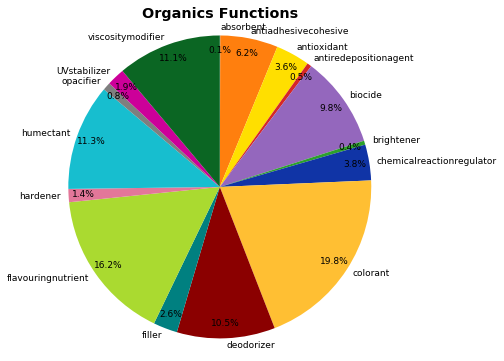

In [71]:
# Organics function breakdown as pie chart
plot_piechart(data=Xf_source.sum(axis=0), 
              labels=source_func_names, 
              save_fig_name='Organics Functions')

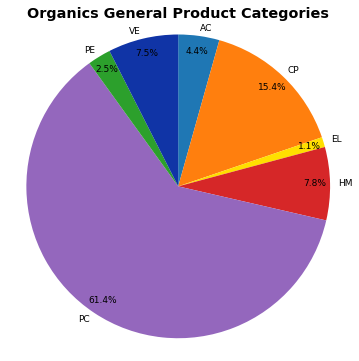

In [72]:
# Organics PUC breakdown as pie chart
plot_piechart(data=Xp_source.values[:,0:7].sum(axis=0), 
              labels=source_PUC_names[0:7], 
              save_fig_name='Organics General Product Categories')

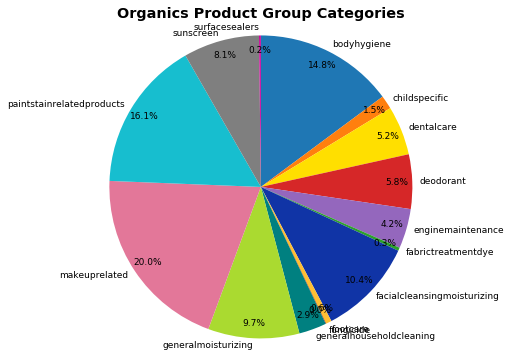

In [73]:
# Organics PUC breakdown as pie chart
plot_piechart(data=Xp_source.values[:,7:].sum(axis=0), 
              labels=source_PUC_names[7:], 
              save_fig_name='Organics Product Group Categories')

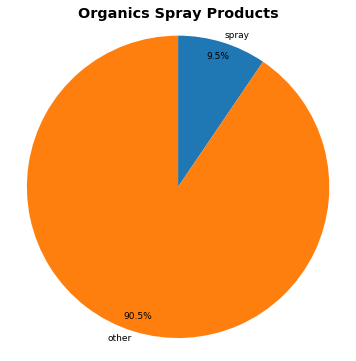

In [74]:
# Organics spray products as pie chart
labels = ['spray','other']
values = [(np.count_nonzero(X_source['mtrx_spray'])), 
          (len(X_source['mtrx_spray']) \
           - np.count_nonzero(X_source['mtrx_spray']))]
plot_piechart(data=values, 
              labels=labels, 
              save_fig_name='Organics Spray Products')

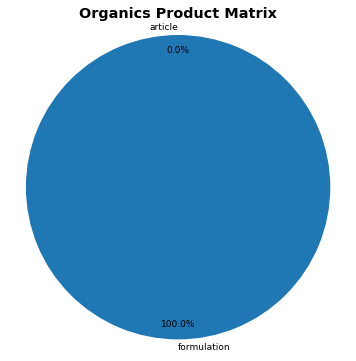

In [75]:
# Organics product matrices as pie chart
labels = ['formulation','article']
values = [(np.count_nonzero(X_source['mtrx_formulation'])), 
          (len(X_source['mtrx_formulation']) - np.count_nonzero(X_source['mtrx_formulation']))]
plot_piechart(data=values, 
              labels=labels, 
              save_fig_name='Organics Product Matrix')

## PCA

Fit PCA to ENM data, then apply to organics.

In [76]:
# Scale the data first (i.e., chemical properties) from 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_enm)
X_enm_scaled = scaler.transform(X_enm)
X_source_scaled = scaler.transform(X_source)

# Transform/apply PCA
from sklearn import decomposition 
pca = decomposition.PCA(n_components=11)
pca.fit(X_enm_scaled)
dim_red_source = pd.DataFrame(pca.transform(X_source_scaled))

# Export PCA dataframe
dim_red_source.to_csv("./data/organics-PCA-feats.csv", sep='\t', na_rep='', 
                      header=True, index=True, index_label=None, mode='w')

## Hierarchical Agglomerative Clustering (HAC)

In [25]:
# Apply feature agglomeration to functional use and PUC features
Xf_source_red = blt.feat_agglom(13, 'fagg', Xf_enm, Xf_source)
Xp_source_red = blt.feat_agglom(16, 'pagg', Xp_enm, Xp_source)

# Make sure indices match
Xf_source_red.index = Xc_source.index
Xp_source_red.index = Xc_source.index

# Drop boiling point as per ENM data
Xc_source = Xc_source.drop(['cprp_BP'], axis=1)

In [26]:
# Concatenate all clustered features into new dataframe
XX_source = pd.concat([Xc_source, Xf_source_red, Xp_source_red, Xm_source], 
                      axis=1)
XX_source.tail(10)

,cprp_MW,cprp_MP,cprp_logdensity,fagg_absorbent_opacifier,fagg_brightener_viscositymodifier,fagg_filler_humectant,func_UVstabilizer,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,...,pgrp_dentalcare,pgrp_deodorant,pgrp_facialcleansingmoisturizing,pgrp_footcare,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
29361,152.149,84.03215,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
29362,152.149,84.03215,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
29363,152.149,84.03215,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29364,152.149,84.03215,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
29365,152.149,84.03215,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
29366,152.149,84.03215,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
29367,152.149,84.03215,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
29368,152.149,84.03215,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
29369,135.210,-31.78080,-0.031517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29370,135.210,-31.78080,-0.031517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [27]:
# Export unscaled organics dataframe
XX_source.to_csv("./data/organics-preprocessed-feats.csv", 
                 sep='\t', na_rep='', header=True, 
                 index=True, index_label=None, mode='w')

In [28]:
# Export organics dataframe without feature reduction
X_source.to_csv("./data/organics-pre-preprocessed-feats.csv", 
                sep='\t', na_rep='', header=True, 
                index=True, index_label=None, mode='w')

In [29]:
# Export organics WF labels
y_source.to_csv("./data/organics-preprocessed-WF.csv", sep='\t', na_rep='', 
                 header=True, index=True, index_label=None, mode='w')